## Data

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

torch.manual_seed(11)

def crop(X):
    res = np.zeros((len(X), len(X[0]), 300, 300))
    for p in range(len(X)):
        for s in range(len(X[p])):
            for i in range(106, 406):
                res[p][s][i - 106] = X[p][s][i][106:406]
    return res


# MRIs
X = np.load('small_data.npy')
X = crop(X)


# labels
y = pd.read_csv('all_target.csv')
y.columns = ['y']

# devide into 2 classes: no cut / cut - (0 / 1)
y = np.where(y.y <= 3, 0, 1)

## Leave 22% of entire patient MRI sets untouched for testing

18 of 81 patients (9 from each group) are removed in order to test the multi-modular model.

In [11]:
# Find all ill and healthy indeces
ill_inds = np.argwhere(y==0).flatten()
hea_inds = np.argwhere(y==1).flatten()

# Choose 9 from each group for further testing 
ill_test_inds = np.random.choice(ill_inds, 3, replace=False)
hea_test_inds = np.random.choice(hea_inds, 7, replace=False)

test_inds = [*ill_test_inds, *hea_test_inds]
train_inds = [i for i in range(len(y)) if i not in test_inds]

X_TEST = X[test_inds]
Y_TEST = y[test_inds]

# leave the rest and use as the main data
X = X[train_inds]
y = y[train_inds]

print(f'X shape = {X.shape}')
print(f'X Frozen shape = {X_TEST.shape}')

X shape = (71, 10, 300, 300)
X Frozen shape = (10, 10, 300, 300)


## SMOTE Balance

In [13]:
np.unique(y, return_counts=True)

(array([0, 1]), array([65,  6]))

In [21]:
len(X_TEST)

10

In [15]:
import imblearn
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_temp = X.reshape((710, -1))
y_temp = np.array([[i]*10 for i in y]).reshape((710, -1))

X_smote, y_smote = sm.fit_resample(X_temp, y_temp)

np.unique(y_smote, return_counts=True)

(array([0, 1]), array([650, 650]))

## Transformation

In [22]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.33, random_state=42)

# count classes
print(f'Class counts in test data: {np.unique(y_test, return_counts=True)}')
print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')

# From numpy to torch
X = torch.from_numpy(X).to(torch.float32)
y = torch.from_numpy(y)

X_train = torch.from_numpy(X_train).to(torch.float32)
X_test = torch.from_numpy(X_test).to(torch.float32)
y_test = torch.from_numpy(y_test)

X_TEST = torch.from_numpy(X_TEST)
Y_TEST = torch.from_numpy(Y_TEST)

# Reshaping
X_train = X_train.unsqueeze(1).reshape((871, 1, 300, 300))
X_test = X_test.unsqueeze(1).reshape((429, 1, 300, 300))

X_TEST = X_TEST.unsqueeze(1).reshape((100, 1, 300, 300))
Y_TEST = torch.tensor([[i]*10 for i in Y_TEST])
Y_TEST = Y_TEST.flatten()

## Model Part 1: CNN

In [23]:
class deep_simple(nn.Module):
    def __init__(self, batch_size):
        super().__init__()
        
        self.batch_size = batch_size
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.class_layers = nn.Sequential(
            nn.Linear(16*146*146, 1000),
            nn.ReLU(),
            nn.Linear(1000, 100),
            nn.Linear(100, 10),
            nn.Linear(10, 2)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.class_layers(x.reshape((self.batch_size, -1, 16*146*146)))
        
        return x

In [9]:
X_train.shape

torch.Size([790, 1, 300, 300])

In [7]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([384, 406]))

## Training & Validation

In [24]:
# Batches
batch_size = 10

# X_train
X_train_loader = torch.utils.data.DataLoader(
    X_train,
    batch_size=batch_size
)

# y_train
y_train_loader = torch.utils.data.DataLoader(
    y_train,
    batch_size=batch_size
)

In [7]:
for i in X_train_loader:
    print(i.shape)
    break

torch.Size([10, 1, 300, 300])


In [8]:
y_train.shape

(790,)

In [38]:
ds = deep_simple(batch_size)

criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(ds.parameters(), lr=0.01)

n_epochs = 100
last_acc = 0.
best_acc = 0.98
cnt_s = 0

losses = []
acc_t = []
acc_f = []
samples = []

for n in range(n_epochs):
    
    # training
    y_train_iter = iter(y_train_loader)
    cnt_0 = 0
    
    for sample in X_train_loader:
        labels = next(y_train_iter)
        preds = ds(sample.to(torch.float32)).view(batch_size, 2)
        loss = criterion(preds, labels)
        loss.backward()
        
        optim.step()
        optim.zero_grad()
        
        cnt_0 += 1
        if cnt_0 == 6:
            print(f'loss = {round(loss.item(), 4)}')
            losses.append(loss)
            cnt_0 = 0
            cnt_s += 1
            # testing
            with torch.no_grad():
                test_preds = ds(X_test.to(torch.float32)).reshape((429, -1))
                cnt = 0
                for i, pred in enumerate(test_preds):
                    cnt += torch.argmax(pred) == y_test[i]

                acc = cnt / 390
                acc_t.append(acc)
                ss = 6 * cnt_s + 790 * n
                samples.append(ss)
                print(f'Samples seen: {ss}  Test Accuracy = {round(acc.item(), 5)}', end = '\t')
                
                
            #FROZEN
            with torch.no_grad():
                test_preds = ds(X_TEST.to(torch.float32)).reshape((100, -1))
                tp = 0
                tn = 0
                fp = 0
                fn = 0
                for i, pred in enumerate(test_preds):
                    if torch.argmax(pred) == Y_TEST[i]:
                        if Y_TEST[i] == 1:
                            tp += 1
                        else:
                            tn += 1

                    else:
                        if Y_TEST[i] == 1:
                            fn += 1
                        else:
                            fp += 1

                acc1 = (tp + tn) / 180
                acc_f.append(acc1)
                print(f'FROZEN Accuracy = {round(acc1, 5)}')
#                 print(np.array([[tp, fp], [fn, tn]]))
            
            if best_acc < (acc + acc1)/2:
                best_acc = (acc + acc1)/2
                torch.save(ds.state_dict(), 'dm1_ds_v.3_dict.pth')
       
    # testing
    with torch.no_grad():
        test_preds = ds(X_test.to(torch.float32)).reshape((429, -1))
        cnt = 0
        for i, pred in enumerate(test_preds):
            cnt += torch.argmax(pred) == y_test[i]

        acc = cnt / 390
        print(f'E{n+1}  Accuracy = {round(acc.item(), 5)}')
    
    if torch.abs(acc - last_acc) < 0.001:
        break

loss = 1.4309


RuntimeError: shape '[10, -1, 341056]' is invalid for input of size 146313024

In [ ]:
# torch.save(ds.state_dict(), 'dm1_ds_dict.pth')

In [10]:
model = deep_simple(10)
model.load_state_dict(torch.load('dm1_ds_v.3_dict.pth'))
model.eval()

with torch.no_grad():
    test_preds = model(X_test.to(torch.float32)).reshape((390, -1))
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i, pred in enumerate(test_preds):
        if torch.argmax(pred) == y_test[i]:
            if y_test[i] == 1:
                tp += 1
            else:
                tn += 1
        
        else:
            if y_test[i] == 1:
                fn += 1
            else:
                fp += 1
    
    acc = (tp + tn) / 390
    print(f'Accuracy = {round(acc, 5)}')
    print(np.array([[tp, fp], [fn, tn]]))

Accuracy = 1.73889
[[112   5]
 [ 72 201]]


## Testing on frozen data 

(55, 55)

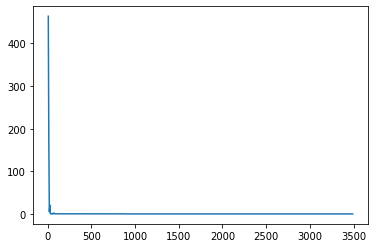

In [34]:
# losses = [i.item() for i in losses]
plt.plot(samples, losses[:-1])

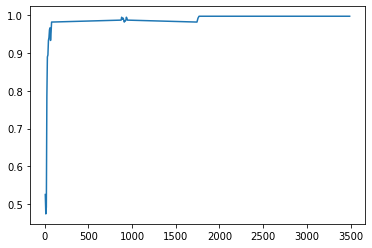

In [35]:
plt.plot(samples, acc_t)

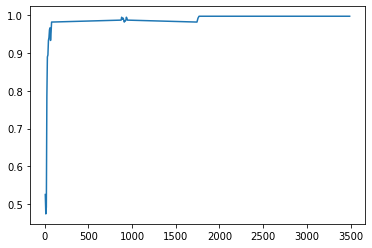

In [36]:
plt.plot(samples, acc_f)

In [ ]:
X_test.shape, X_TEST.shape

In [ ]:
y_test.shape, Y_TEST.shape

In [11]:
with torch.no_grad():
    test_preds = model(X_TEST.to(torch.float32)).reshape((180, -1))
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i, pred in enumerate(test_preds):
        if torch.argmax(pred) == Y_TEST[i]:
            if Y_TEST[i] == 1:
                tp += 1
            else:
                tn += 1
        
        else:
            if Y_TEST[i] == 1:
                fn += 1
            else:
                fp += 1
    
    acc = (tp + tn) / 180
    print(f'Accuracy = {round(acc, 5)}')
    print(np.array([[tp, fp], [fn, tn]]))

Accuracy = 0.72222
[[41  1]
 [49 89]]


## Model Part 2: Multi-Modularity

In [ ]:
# MMDS(ds, X_TEST, Y_TEST)

In [ ]:
# torch.save(ds.state_dict(), 'MMDS_0_dict.pth')

In [ ]:
ds_m = deep_simple(batch_size)
ds_m.load_state_dict(torch.load('MMDS_0_dict.pth'))
ds_m.eval()
print()

In [ ]:
class deep_mod(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.class_layer = nn.Sequential(
            nn.Linear(10, 1000),
            nn.Linear(1000, 1000),
            nn.Linear(1000, 100),
            nn.Linear(100, 10),
            nn.Linear(10, 2)
        )
        
    def forward(self, x):
        x = self.class_layer(x)
        
        return x

In [ ]:
ds = deep_simple(batch_size)
ds.load_state_dict(torch.load('full_MMDS_p1_dict.pth'))
ds.eval()

dm = deep_mod()
dm.load_state_dict(torch.load('full_MMDS_p2_dict.pth'))
dm.eval()

best_acc = 0.84
optim = torch.optim.Adam(dm.parameters(), lr=0.008)
mod_cnt = 2
for epoch in range(20):
    print(f'Epoch: {epoch+1}\t avg loss:', end = ' ')
    losses = []
    for i, x in enumerate(X.unsqueeze(2)):
        pat = ds(x)
        pat = pat.reshape(10, 2).argmax(axis=1)
        pat = pat.reshape(-1, 10).to(torch.float32)
        res = dm(pat)
        label = y[i].flatten()
        loss = criterion(res, label)
        loss.backward()

        optim.step()
        optim.zero_grad()

        losses.append(loss.item())
    print(round(np.mean(losses), 4), end = '\t')
    
    #TRAIN
    acc = 0
    c = 0
    for i, x in enumerate(X.unsqueeze(2)):
        pat = ds(x)
        pat = pat.reshape(10, 2).argmax(axis=1)
        pat = pat.reshape(-1, 10).to(torch.float32)
        res = dm(pat).flatten().argmax()
        label = y[i].flatten()
        acc += (res == label[0])
        c += 1
    acc = round(acc.item()/c, 4)
    print(f'train acc: {acc}', end = '\t')
        
    # TEST
    acc = 0
    for i, x in enumerate(X_TEST.unsqueeze(2).to(torch.float32)):
        pat = ds_m(x)
        pat = pat.reshape(10, 2).argmax(axis=1)
        pat = pat.reshape(-1, 10).to(torch.float32)
        res = dm(pat).flatten().argmax()
        label = Y_TEST[i].flatten()
        # print(res, label[0])
        acc += (res == label[0])
    acc = round(acc.item()/18, 4)
    print(f'test acc: {acc}')
    
    if acc > best_acc:
        print(f'\t \t MAX !!!')
        torch.save(dm.state_dict(), f'full_{mod_cnt}_MMDS_p2_dict.pth')
        mod_cnt += 1

In [ ]:
# torch.save(ds_m.state_dict(), 'full_MMDS_p1_dict.pth')

In [ ]:
# torch.save(dm.state_dict(), 'full_MMDS_p2_dict.pth')

In [ ]:
ds = deep_simple(batch_size)
ds.load_state_dict(torch.load('full_MMDS_p1_dict.pth'))
ds.eval()

dm = deep_mod()
dm.load_state_dict(torch.load('full_MMDS_p2_dict.pth'))
dm.eval()

In [ ]:
acc = 0
for i, x in enumerate(X_TEST.unsqueeze(2).to(torch.float32)):
    pat = ds_m(x)
    pat = pat.reshape(10, 2).argmax(axis=1)
    pat = pat.reshape(-1, 10).to(torch.float32)
    res = dm(pat).flatten().argmax()
    label = Y_TEST[i].flatten()
    # print(res, label[0])
    acc += (res == label[0])
print(f'test acc: {acc/18}')

## Testing prelearnt model

In [ ]:
ds0 = deep_simple(batch_size)
ds0.load_state_dict(torch.load('deep_simple_dict.pth'))
ds0.eval()

MMDS(ds0, X_TEST, Y_TEST)